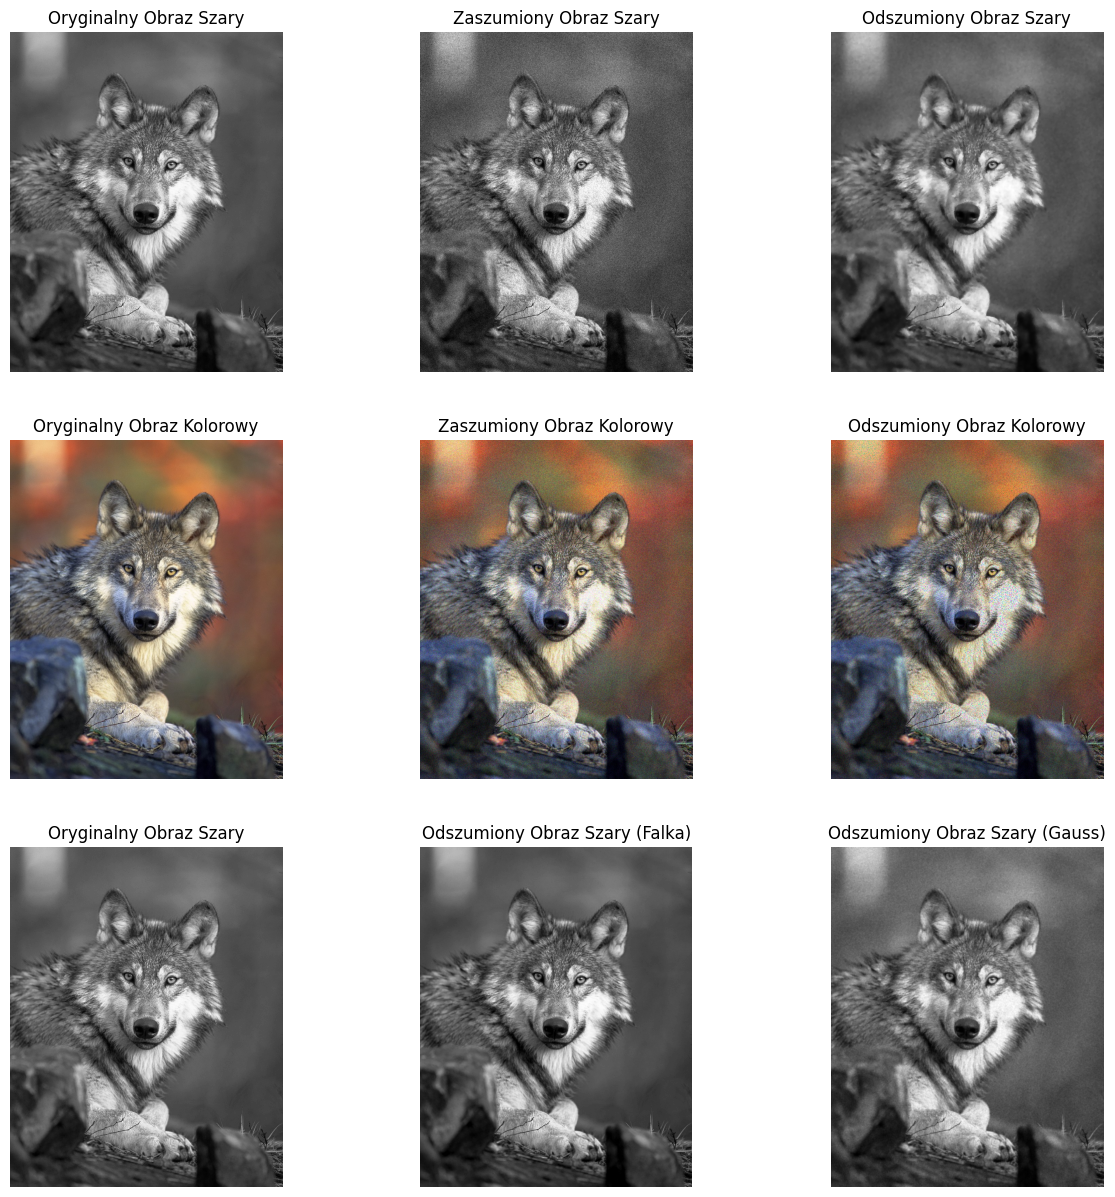

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import pywt
from skimage import io, restoration, color, filters
from scipy import fft

def szum_poissona(obraz: np.ndarray, lambda_wartosc: float) -> np.ndarray:
    zaszumiony_obraz = np.random.poisson(obraz / obraz.max() * lambda_wartosc) / lambda_wartosc
    zaszumiony_obraz = np.clip(zaszumiony_obraz * 255, 0, 255).astype(int)
    return zaszumiony_obraz

def anscombe(x):
    c = 3 / 8
    return 2 * np.sqrt(x + c)

def inv_anscombe(y):
    c = -1 * 3 / 8
    return np.power(0.5 * y, 2) + c

def odszumianie_po_anscombe(obraz):
    x = obraz / obraz.max()
    x = anscombe(x)
    x = restoration.denoise_tv_chambolle(x)
    x = inv_anscombe(x)
    return x

def odszumianie_fourier_kolor_osobno(obraz, procent_progowania):
    odszumiony_obraz = np.zeros_like(obraz, dtype=np.float64)
    for kanal in range(obraz.shape[2]):
        f_transformacja = fft2(obraz[:, :, kanal])
        f_transformacja_przesunieta = fftshift(f_transformacja)
        widmo_amplitudy = np.abs(f_transformacja_przesunieta)
        prog = np.percentile(widmo_amplitudy, procent_progowania)
        f_transformacja_przesunieta[np.abs(widmo_amplitudy) < prog] = 0
        f_transformacja_cofnieta = ifftshift(f_transformacja_przesunieta)
        odszumiony_kanal = np.abs(ifft2(f_transformacja_cofnieta))
        odszumiony_obraz[:, :, kanal] = odszumiony_kanal

    return odszumiony_obraz.astype(np.uint8)

sciezka_obrazu = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Front_view_of_a_resting_Canis_lupus_ssp.jpg/800px-Front_view_of_a_resting_Canis_lupus_ssp.jpg"
obraz = io.imread(sciezka_obrazu)

obraz_szary = cv2.cvtColor(obraz, cv2.COLOR_BGR2GRAY)
zaszumiony_obraz_szary = szum_poissona(obraz_szary, lambda_wartosc=64)
przekształcony_obraz_szary = odszumianie_po_anscombe(zaszumiony_obraz_szary)

zaszumiony_obraz_kolorowy = szum_poissona(obraz, lambda_wartosc=64)
odszyfrowany_obraz_kolorowy_osobno = odszumianie_fourier_kolor_osobno(zaszumiony_obraz_kolorowy, procent_progowania=10)

falka = 'haar'
coeffs2 = pywt.dwt2(obraz_szary, falka)
LL, (LH, HL, HH) = coeffs2
prog = 20
LL_przefiltrowane = pywt.threshold(LL, prog, mode='soft')
LH_przefiltrowane = pywt.threshold(LH, prog, mode='soft')
HL_przefiltrowane = pywt.threshold(HL, prog, mode='soft')
HH_przefiltrowane = pywt.threshold(HH, prog, mode='soft')
coeffs_przefiltrowane = (LL_przefiltrowane, (LH_przefiltrowane, HL_przefiltrowane, HH_przefiltrowane))
rekonstruowany_obraz = pywt.idwt2(coeffs_przefiltrowane, falka)

szary_zaszumiony_obraz = color.rgb2gray(zaszumiony_obraz_kolorowy)
gaussian_przefiltrowany_obraz = filters.gaussian(szary_zaszumiony_obraz, sigma=1)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

axes[0, 0].imshow(obraz_szary, cmap='gray')
axes[0, 0].set_title('Oryginalny Obraz Szary')
axes[0, 0].axis('off')

axes[0, 1].imshow(zaszumiony_obraz_szary, cmap='gray')
axes[0, 1].set_title('Zaszumiony Obraz Szary')
axes[0, 1].axis('off')

axes[0, 2].imshow(przekształcony_obraz_szary, cmap='gray')
axes[0, 2].set_title('Odszumiony Obraz Szary')
axes[0, 2].axis('off')

axes[1, 0].imshow(obraz)
axes[1, 0].set_title('Oryginalny Obraz Kolorowy')
axes[1, 0].axis('off')

axes[1, 1].imshow(zaszumiony_obraz_kolorowy)
axes[1, 1].set_title('Zaszumiony Obraz Kolorowy')
axes[1, 1].axis('off')

axes[1, 2].imshow(odszyfrowany_obraz_kolorowy_osobno)
axes[1, 2].set_title('Odszumiony Obraz Kolorowy')
axes[1, 2].axis('off')

axes[2, 0].imshow(obraz_szary, cmap='gray')
axes[2, 0].set_title('Oryginalny Obraz Szary')
axes[2, 0].axis('off')

axes[2, 1].imshow(rekonstruowany_obraz, cmap='gray')
axes[2, 1].set_title('Odszumiony Obraz Szary (Falka)')
axes[2, 1].axis('off')

axes[2, 2].imshow(gaussian_przefiltrowany_obraz, cmap='gray')
axes[2, 2].set_title('Odszumiony Obraz Szary (Gauss)')
axes[2, 2].axis('off')

plt.show()